# Пример работы GCN  на задаче Karate Club

<img src="karate.png">

In [608]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
from sklearn.metrics import accuracy_score
from statistics import mean


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': '30',
         'axes.titlesize':'35',
         'xtick.labelsize':'30',
         'ytick.labelsize':'30'}
pylab.rcParams.update(params)

DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [609]:
from networkx import connected_components, to_numpy_matrix, degree_centrality,degree,  betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd

zkc = load_karate_club()

A = to_numpy_matrix(zkc.network)
A = nd.array(A)

X_train = zkc.X_train.flatten()
y_train = zkc.y_train
X_test = zkc.X_test.flatten()
y_test = zkc.y_test

# Определение слоев

In [610]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [611]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Модели

In [612]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

## Модель 1 : one-hot закодированные вершины

In [613]:
X_1 = I = nd.eye(*A.shape)
print("Done")

Done


## Модель 2 : дистанция до администратора и интсруктора в качестве дополнительных признаков

In [614]:
X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)

for node in zkc.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]

In [615]:
X_2 = nd.concat(X_1, X_2)
print("Done")

Done


## Модель 3 : расстояния до Администратора и Инструктора + степень вершины + произведение путей, деленное на степень


In [616]:
X_3 = nd.zeros((A.shape[0], 4))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)
node_degree = degree(zkc.network)
for node in zkc.network.nodes():
    X_3[node][0] = node_distance_administrator[node]
    X_3[node][1] = node_distance_instructor[node]
    X_3[node][2] = node_degree[node]
    X_3[node][3] = node_distance_instructor[node]*node_distance_administrator[node]/node_degree[node]
print("Done")

Done


## Модель 4 : Модель 2 + разность расстояний до администратора и интсруктора

In [617]:
X_4 = nd.zeros((A.shape[0], 4))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)
node_degree = degree(zkc.network)
for node in zkc.network.nodes():
    X_4[node][0] = node_distance_administrator[node]
    X_4[node][1] = node_distance_instructor[node]
    X_4[node][2] = X_4[node][1] - X_4[node][0]
print("Done")

Done


# Тренируем и тестируем модели

In [618]:
%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        #    print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        #    print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

accuracy = []
accuracy_max = []

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


## Оценки первой модели

In [619]:
from sklearn.metrics import classification_report
acc = []
for i in range(10):
    model_1, features_1 = build_model(A, X_1)
    model_1(X_1)
    feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=250)
    y_pred_1 = predict(model_1, X_1, X_test)
    acc.append(accuracy_score(y_test, y_pred_1))
accuracy.append(mean(acc))
accuracy_max.append(max(acc))

## Оценки второй модели

In [620]:
acc = []
for i in range(10):
    model_2, features_2 = build_model(A, X_2)
    model_2(X_2)
    feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
    y_pred_2 = predict(model_2, X_2, X_test)
    acc.append(accuracy_score(y_test, y_pred_2))
accuracy.append(mean(acc))
accuracy_max.append(max(acc))

## Оценки третьей модели

In [621]:
acc = []
for i in range(10):
    model_3, features_3 = build_model(A, X_3)
    model_3(X_3)
    feature_representations_3= train(model_3, features_3, X_3, X_train, y_train, epochs=350)
    y_pred_3 = predict(model_3, X_3, X_test)
    acc.append(accuracy_score(y_test, y_pred_3))
accuracy.append(mean(acc))
accuracy_max.append(max(acc))

## Оценки 4 модели

In [622]:
acc = []
for i in range(10):
    model_4, features_4 = build_model(A, X_4)
    model_4(X_4)
    feature_representations_4= train(model_4, features_4, X_4, X_train, y_train, epochs=350)
    y_pred_4 = predict(model_4, X_4, X_test)
    acc.append(accuracy_score(y_test, y_pred_4))
accuracy.append(mean(acc))
accuracy_max.append(max(acc))

In [623]:
print("Average accuracy {}".format(accuracy))
print("Max accuracy {}".format(accuracy_max))

Average accuracy [0.46875, 0.925, 0.8875, 0.921875]
Max accuracy [0.5, 0.96875, 0.96875, 0.96875]


# Результаты (архитектура моделей : $accuracy_{avg}$ - $accuracy_{max}$)
(6, 'tanh'),(4, 'tanh'), (2, 'tanh') : [0.515625, 0.775, 0.659375, 0.559375]-
                                       [0.59375, 0.90625, 0.84375, 0.59375]
                    
(4, 'tanh'),(4, 'tanh'), (2, 'tanh') : [0.51875, 0.71875, 0.65, 0.559375]-
[0.625, 0.90625, 0.875, 0.625]

(4, 'tanh'),(4, 'tanh'), (2, 'tanh'), (2, 'tanh') : [0.503125, 0.678125, 0.703125, 0.6375]-
[0.53125, 0.84375, 0.875, 0.8125]

tanh2 [0.503125, 0.921875, 0.821875, 0.9125]-
[0.5625, 0.96875, 0.96875, 0.9375]

relu2 [0.49375, 0.640625, 0.6, 0.9]-
[0.59375, 0.84375, 0.84375, 0.9375]

tanh2+relu2 [0.528125, 0.640625, 0.63125, 0.73125]-
[0.625, 0.9375, 0.90625, 0.90625]

tanh2+tanh2 [0.528125, 0.715625, 0.753125, 0.89375]-
[0.59375, 0.90625, 0.9375, 0.90625]

# Таким образом, по результатам эксперимента выбираем 3 модель с архитектурой tanh2 

In [660]:

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        #    print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        #    print(cum_preds)
    return feature_representations



model_4, features_4 = build_model(A, X_4)
model_4(X_4)
feature_representations_4= train(model_4, features_4, X_4, X_train, y_train, epochs=350)
y_pred_4 = predict(model_4, X_4, X_test)

In [661]:
filenames = []
def plot_repr(feature_representations):
    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []


    for i in range(len(y_test)):
        if y_test[i]:
            pos_x.append(feature_representations[i][0])
            pos_y.append(feature_representations[i][1])
            continue
        neg_x.append(feature_representations[i][0])
        neg_y.append(feature_representations[i][1])
        
    plt.scatter(feature_representations[0][0], feature_representations[0][1], s = 1000)
    plt.scatter(feature_representations[-1][0], feature_representations[-1][1],  s = 1000)
    plt.scatter(neg_x, neg_y, marker='+', s = 1000)
    plt.scatter(pos_x, pos_y, marker='+', s = 1000)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title("Epoch 350")
    plt.grid()
    plt.show()
    
def save_plot_repr(feature_representations, e):
    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []


    for i in range(len(y_test)):
        if y_test[i]:
            pos_x.append(feature_representations[i][0])
            pos_y.append(feature_representations[i][1])
            continue
        neg_x.append(feature_representations[i][0])
        neg_y.append(feature_representations[i][1])
    plt.scatter(feature_representations[0][0], feature_representations[0][1], s = 1000)
    plt.scatter(feature_representations[-1][0], feature_representations[-1][1],  s = 1000)
    plt.scatter(neg_x, neg_y, marker='+', s = 1000)
    plt.scatter(pos_x, pos_y, marker='+', s = 1000)
    plt.grid()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title("Epoch {}".format(e))
    string = 'scatter' + str(e) + '.png'
    plt.savefig(string)
    filenames.append(string)
    plt.clf()

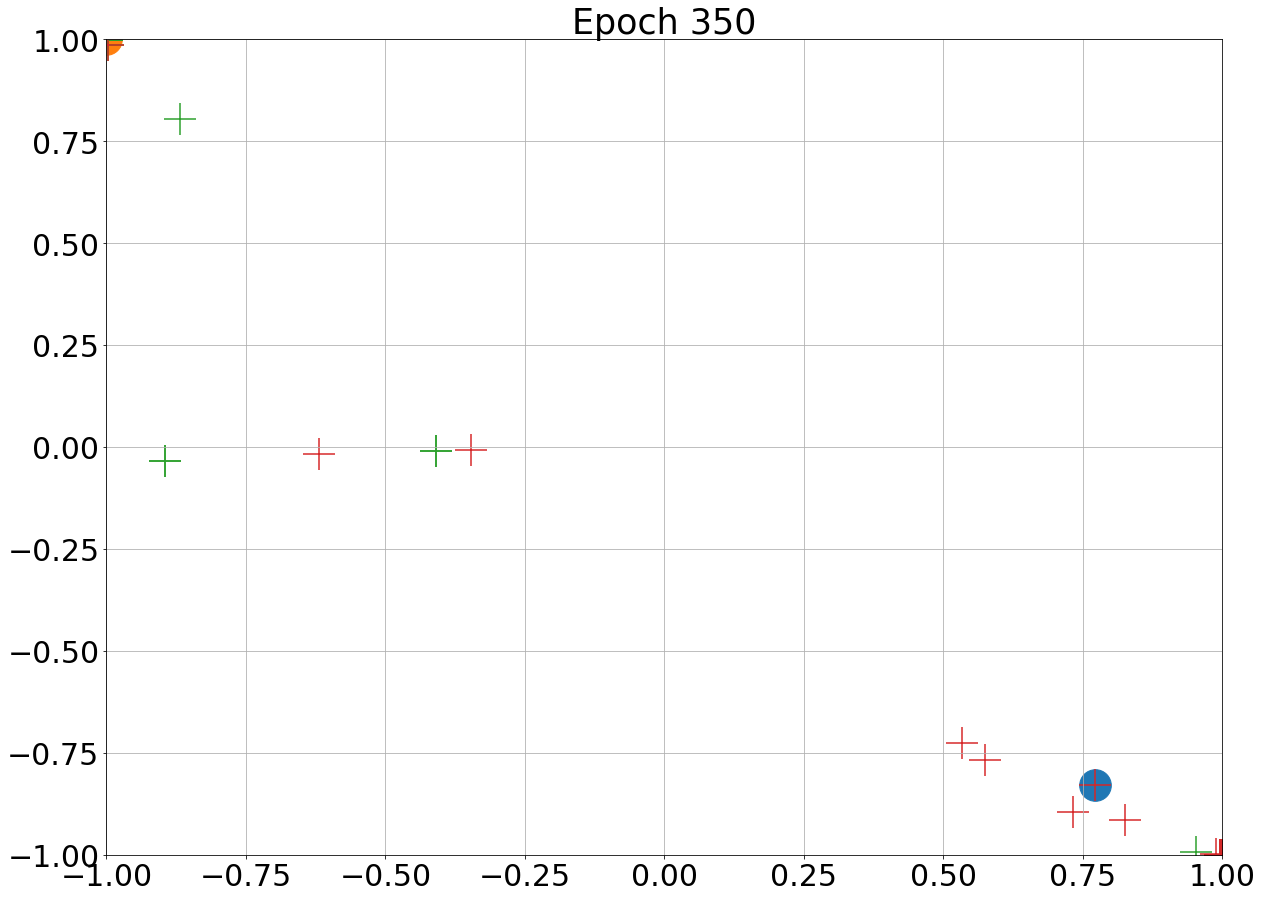

In [662]:
feature_representations = feature_representations_4[-1]
plot_repr(feature_representations)

### Посмотрим на метки в процессе обучения

In [663]:
def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % 3) == 0:
            save_plot_repr(feature_representations[-1], e)
    return feature_representations



In [664]:
model_4, features_4 = build_model(A, X_4)
model_4(X_4)
feature_representations_4= train(model_4, features_4, X_4, X_train, y_train, epochs=350)
y_pred_4 = predict(model_4, X_4, X_test)
print("Accuracy : {}".format(accuracy_score(y_test, y_pred_4)))

Accuracy : 0.90625


<Figure size 1440x1080 with 0 Axes>

In [665]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)